In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import heapq
import geopandas as gpd
import plotly.graph_objects as go
import copy
import geopy
import multiprocessing
from joblib import Parallel, delayed

In [2]:
# read the csv file

# the simple one 
roads_df = gpd.read_file('data/ubcv_roads_simple.geojson')

# the complex one
# roads_df = gpd.read_file('data/ubcv_routes.geojson')

<Axes: >

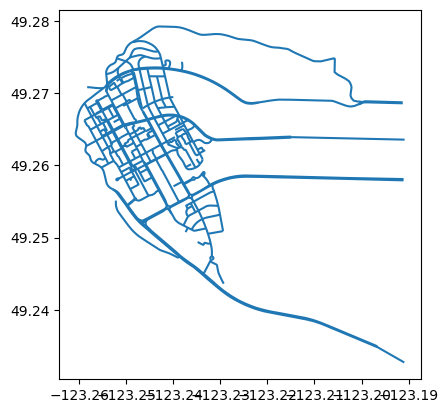

In [3]:
roads_df.plot()

In [4]:
buildings_df = pd.read_csv('data/ubcv_buildings_simple.csv')

# combine the two dataframes
# should be avoided
df = pd.concat([roads_df, buildings_df], axis=0, ignore_index=True)


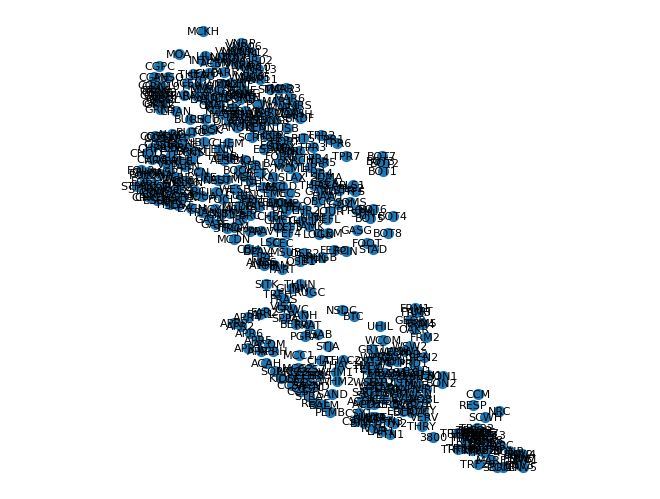

In [5]:
# create a graph

G = nx.Graph()
'''
# add nodes
for i in range(len(df)):
    if df["NAME"][i] == None:
        G.add_node("NaN", pos=(df["LONG"][i], df["LAT"][i]))
    else:
        G.add_node(df['NAME'][i], pos=(df['LONG'][i], df['LAT'][i]))
'''

for i in range(len(buildings_df)):
    
    G.add_node(buildings_df["BLDG_CODE"][i], pos=(-buildings_df["LONG"][i], -buildings_df["LAT"][i]))

# draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)

# Ensure equal aspect ratio
plt.axis('equal')

plt.show()

In [38]:
def calculate_distance(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def create_fig(edge_trace=[], node_trace=None, name="", width=1200, height=1200):
    data = []

    # Handle edge traces (list of traces or a single trace)
    if isinstance(edge_trace, list):
        data.extend(edge_trace)  # Add all traces in the list
    elif isinstance(edge_trace, go.BaseTraceType):
        data.append(edge_trace)  # Add single trace
    else:
        raise ValueError("edge_trace must be a list of traces or a single valid Plotly trace object.")

    # Handle node trace (single trace)
    if isinstance(node_trace, go.BaseTraceType):
        data.append(node_trace)  # Add single node trace
    elif node_trace is not None:
        raise ValueError("node_trace must be a single valid Plotly trace object.")

    # Create the figure
    fig = go.Figure(data=data)

    # Set layout for equal aspect ratio
    fig.update_layout(
        title=name,
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        template="plotly_white",
        width=width,  # Set the width of the figure
        height=height   # Set the height of the figure
    )

    # Make the x and y scales the same to avoid distortion
    fig.update_xaxes(scaleanchor="y", scaleratio=1)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)

    return fig

def create_nodes(node_x, node_y, node_text, mode='markers', color = 'blue'):
    if color == 'blue':
        color = ['blue'] * len(node_text)
        
    node_colors = [
        'red' if color == 'red' else 
        ('black' if len(text) > 5 else 'green')
        for text, color in zip(node_text, color)
    ]
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode=mode,
        marker=dict(
            size=10,
            color= node_colors,
            line=dict(width=2, color=node_colors)
        ),
        text=node_text,
        textposition="top center",
        hoverinfo='text'
    )
    return node_trace

def create_edges(edge_x, edge_y, color='#888'):
    edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color=color),
    hoverinfo='none',
    mode='lines'
    )
    return edge_trace

In [7]:
import networkx as nx
import plotly.graph_objects as go
import pandas as pd

# Create a graph
building_G = nx.Graph()

# Add nodes with positions
for i in range(len(buildings_df)):
    building_G.add_node(
        buildings_df["BLDG_CODE"][i], 
        pos=(buildings_df["LAT"][i], buildings_df["LONG"][i])
    )

# Extract positions of nodes
pos = nx.get_node_attributes(building_G, 'pos')


# Create node traces
node_x = [x for node, (x, y) in pos.items()]
node_y = [y for node, (x, y) in pos.items()]
node_text = [str(node) for node, (x, y) in pos.items()]

edge_trace = create_edges([], [])    
node_trace = create_nodes(node_x, node_y, node_text)
fig = create_fig(edge_trace, node_trace, name = "Building map, missing roads and edges", width=800, height=1200)

fig.show()

In [8]:
# Create a graph
roads_G = nx.Graph()

listOfCoords = []
# Add nodes with positions
for i in range(len(roads_df)):
    geometry = roads_df["geometry"][i]
    
    if geometry.geom_type == "LineString":
        # Iterate through coordinates in LineString
        for j, (long, lat) in enumerate(geometry.coords):
            if (long, lat) not in listOfCoords:
                if long > -123.2277783865:
                    continue
                listOfCoords.append((long, lat))
                name = roads_df["NAME"][i] if "NAME" in roads_df.columns and pd.notna(roads_df["NAME"][i]) else f"road_{i}"
                node_id = name + f"_point_{j}"  
                roads_G.add_node(
                    node_id,
                    pos=(long, lat)  # Add coordinates as positions
                )
    elif geometry.geom_type == "MultiLineString":
        # Iterate through each LineString in MultiLineString
        for j, line in enumerate(geometry.geoms):  # `geometry.geoms` gives LineString objects
            for k, (long, lat) in enumerate(line.coords):
                if (long, lat) not in listOfCoords:
                    if long > -123.2277783865:
                        continue
                    listOfCoords.append((long, lat))
                    name = roads_df["NAME"][i] if "NAME" in roads_df.columns and pd.notna(roads_df["NAME"][i]) else f"road_{i}"
                    node_id = name + f"_line_{j}_point_{k}"
                    roads_G.add_node(
                        node_id,
                        pos=(long, lat)  # Add coordinates as positions
                    )

# Extract positions of nodes
pos = nx.get_node_attributes(roads_G, 'pos')

node_x = [x for node, (x, y) in pos.items()]
node_y = [y for node, (x, y) in pos.items()]
node_text = [str(node) for node, (x, y) in pos.items()]

edge_trace = create_edges([], [])
node_trace = create_nodes(node_x, node_y, node_text)
fig = create_fig(edge_trace, node_trace, name = "Road map, missing buildings and edges")
fig.show()

In [9]:
merged_G_noedges = nx.Graph()

for node in roads_G.nodes(data=True):
    merged_G_noedges.add_node(node[0], pos=node[1]['pos'])

for node in building_G.nodes(data=True):
    merged_G_noedges.add_node(node[0], pos=node[1]['pos'])

# Extract positions of nodes for visualization
pos = nx.get_node_attributes(merged_G_noedges, 'pos')

node_x = [x for node, (x, y) in pos.items()]
node_y = [y for node, (x, y) in pos.items()]
node_text = [str(node) for node, (x, y) in pos.items()]

edge_x = []
edge_y = []
edge_trace = create_edges(edge_x, edge_y)
node_trace = create_nodes(node_x, node_y, node_text)

fig = create_fig(edge_trace, node_trace, name="Combined Building & Road Map, no edges", width=800, height=1200)

fig.show()


In [15]:
import networkx as nx
from geopy.distance import geodesic
from joblib import Parallel, delayed

# Initialize the merged graph
merged_G = nx.Graph()

# Add nodes with positions from both graphs
for node, data in building_G.nodes(data=True):
    merged_G.add_node(node, pos=data['pos'])

for node, data in roads_G.nodes(data=True):
    merged_G.add_node(node, pos=data['pos'])

# Helper function to calculate distance
def calculate_distance(pos1, pos2):
    pos1 = (pos1[1], pos1[0])
    pos2 = (pos2[1], pos2[0])
    return geodesic(pos1, pos2).meters

# Identify building and road nodes
buildings = {node for node in merged_G.nodes() if len(node) <= 6}
roads = {node for node in merged_G.nodes() if len(node) > 6}

NUM_CLOSEST_NODES = 3

# Function to find the NUM_CLOSEST_NODES closest roads for a given building
def closest_roads_for_building(building):
    building_coord = merged_G.nodes[building]['pos']
    distances = [
        (building, road, calculate_distance(building_coord, merged_G.nodes[road]['pos']))
        for road in roads
    ]
    distances.sort(key=lambda x: x[2])
    return distances[:NUM_CLOSEST_NODES]

# Parallelize calculating distances from buildings to roads
building_edges = Parallel(n_jobs=-1)(delayed(closest_roads_for_building)(building) for building in buildings)

# Add edges to the graph for buildings
for edges in building_edges:
    for building, road, distance in edges:
        merged_G.add_edge(building, road, weight=distance)

# Function to find the NUM_CLOSEST_NODES closest nodes for a given road
def closest_nodes_for_road(road1):
    road1_coord = merged_G.nodes[road1]['pos']
    distances = [
        (road1, node, calculate_distance(road1_coord, merged_G.nodes[node]['pos']))
        for node in merged_G.nodes() if node != road1
    ]
    distances.sort(key=lambda x: x[2])
    return distances[:NUM_CLOSEST_NODES]

# Parallelize calculating distances from roads to all other nodes
road_edges = Parallel(n_jobs=-1)(delayed(closest_nodes_for_road)(road1) for road1 in roads)

# Add edges to the graph for roads
for edges in road_edges:
    for road1, node, distance in edges:
        merged_G.add_edge(road1, node, weight=distance)

# Add additional edges to connect neighboring points within roads
for road in roads:
    if "line" in road:  # Multiline string
        roadName = road.split("_line_")[0]
        lineNum = int(road.split("_line_")[1].split("_point_")[0])
        pointNum = int(road.split("_point_")[1])
        
        # Check for previous point
        if pointNum > 0:
            prev_point_label = f"{roadName}_line_{lineNum}_point_{pointNum - 1}"
            if prev_point_label in roads:  # Check existence
                weight = calculate_distance(
                    merged_G.nodes[road]['pos'], merged_G.nodes[prev_point_label]['pos']
                )
                merged_G.add_edge(road, prev_point_label, weight=weight)

        # Check for next point
        next_point_label = f"{roadName}_line_{lineNum}_point_{pointNum + 1}"
        if next_point_label in roads:  # Check existence
            weight = calculate_distance(
                merged_G.nodes[road]['pos'], merged_G.nodes[next_point_label]['pos']
            )
            merged_G.add_edge(road, next_point_label, weight=weight)
    
    else:  # Single line string
        roadName = road.split("_point_")[0]
        pointNum = int(road.split("_point_")[1])
        
        # Check for previous point
        if pointNum > 0:
            prev_point_label = f"{roadName}_point_{pointNum - 1}"
            if prev_point_label in roads:  # Check existence
                weight = calculate_distance(
                    merged_G.nodes[road]['pos'], merged_G.nodes[prev_point_label]['pos']
                )
                merged_G.add_edge(road, prev_point_label, weight=weight)

        # Check for next point
        next_point_label = f"{roadName}_point_{pointNum + 1}"
        if next_point_label in roads:  # Check existence
            weight = calculate_distance(
                merged_G.nodes[road]['pos'], merged_G.nodes[next_point_label]['pos']
            )
            merged_G.add_edge(road, next_point_label, weight=weight)

# Visualization part
combined_pos = nx.get_node_attributes(merged_G, 'pos')

node_x = [x for node, (x, y) in combined_pos.items()]
node_y = [y for node, (x, y) in combined_pos.items()]
node_text = [str(node) for node, (x, y) in combined_pos.items()]

# Extract edges to create edge traces
edge_x = []
edge_y = []
for edge in merged_G.edges(data=True):
    x0, y0 = combined_pos[edge[0]]
    x1, y1 = combined_pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_trace = create_nodes(node_x, node_y, node_text)
edge_trace = create_edges(edge_x, edge_y)
merged_fig = create_fig(edge_trace, node_trace, name="Merged Graph with Edges", width=800, height=1200)

merged_fig.show()

In [16]:
nx.is_connected(merged_G)

True

In [17]:
search_buildings = ["NEST", "ANGU"]
node_colors = []

# Iterate through node text to determine the color for each node
for text in node_trace.text:
    if text in search_buildings:
        node_colors.append('red')  # Set the color to red if the building is in search_buildings
        print(f"Building {text} found in the graph.")
    else:
        node_colors.append('blue')  # Default color is blue

node_trace = create_nodes(node_x, node_y, node_text, color=node_colors)
edge_trace = create_edges(edge_x, edge_y)
fig = create_fig(edge_trace, node_trace, name="Buildings are green, roads are black. Search buildings are red.")
fig.show()


Building ANGU found in the graph.
Building NEST found in the graph.


In [18]:
# find the shortest path from one building to another with the weight
print(nx.shortest_path_length(merged_G, source=search_buildings[0], target=search_buildings[1], weight="weight"))

551.2712638215737


In [39]:
# color the shortest path in red

# Find the shortest path
shortest_path = nx.shortest_path(merged_G, source=search_buildings[0], target=search_buildings[1], weight="weight")

# Separate edges based on the shortest path
shortest_path_edges = set((shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1))

# Separate edge coordinates for edges in the shortest path and the rest
red_edge_x = []
red_edge_y = []
default_edge_x = []
default_edge_y = []

for edge in merged_G.edges():
    x0, y0 = combined_pos[edge[0]]
    x1, y1 = combined_pos[edge[1]]
    if edge in shortest_path_edges or (edge[1], edge[0]) in shortest_path_edges:
        red_edge_x.extend([x0, x1, None])
        red_edge_y.extend([y0, y1, None])
    else:
        default_edge_x.extend([x0, x1, None])
        default_edge_y.extend([y0, y1, None])

# Create edge traces
default_edge_trace = create_edges(default_edge_x, default_edge_y, color='#888')
red_edge_trace = create_edges(red_edge_x, red_edge_y, color='#ff0000')

# Create a list of colors for each node
node_colors = []
for text in node_text:
    if text in search_buildings:
        node_colors.append('red')  # Set the color to red if the building is in search_buildings
    else:
        node_colors.append('blue')  # Default color is blue

# Create the node trace
node_trace = create_nodes(node_x, node_y, node_text, color=node_colors)

# Create a figure with the updated edge and node traces
fig = create_fig([default_edge_trace, red_edge_trace], node_trace, name="Shortest Path in Red")
fig.show()

AttributeError: module 'plotly.graph_objects' has no attribute 'BaseTraceType'